# Ablation of non-EAP circuits

**Background:** A "TinySQL" model takes as input 1) An Instruction, which is an english data request sentence and 2) A Context, which is a SQL table create statement. The model outputs a Response, which is a SQL select statement.  

**Notebook purpose:** Do mean or zero ablation on the circuits of the models that were not selected through EAP.

**Notebook details:** This notebook:
- Was developed on Google Colab using an A100
- Runs with M1 (TinyStories) with base/CS1/CS2/CS3 models.
- Requires a GITHUB_TOKEN secret to access Martian TinySQL code repository.
- Requires a HF_TOKEN secret to access Martian HuggingFace repository.
- Was developed under a grant provided by withmartian.com ( https://withmartian.com )
- Relies on the nnsight library. Also refer the https://nnsight.net/notebooks/tutorials/activation_patching/ tutorial
- Relies on the https://github.com/PhilipQuirke/quanta_mech_interp library for graphing useful nodes.

# Import libraries
Imports standard libraries. Do not read.

In [1]:
# https://nnsight.net/
# Access 0.4 prerelease version (as at Dec 2024)
#!pip install nnsight==0.4.0.dev0
!pip install -U nnsight -q

In [2]:
!pip install pandas plotly -q

In [1]:
from IPython.display import clear_output
import einops
import torch
import plotly.express as px
import plotly.io as pio
# pio.renderers.default = "colab"

import nnsight
from nnsight import LanguageModel, util

In [2]:
from getpass import getpass
# from google.colab import userdata
import gc
import weakref

In [3]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import datetime

In [4]:
!pip install datasets -q

In [5]:
github_token = 'gh_'

!pip install --upgrade git+https://{github_token}@github.com/withmartian/TinySQL.git

import TinySQL as qts

  Cloning https://****@github.com/withmartian/TinySQL.git to /tmp/pip-req-build-gy1nmklk
  Running command git clone --filter=blob:none --quiet 'https://****@github.com/withmartian/TinySQL.git' /tmp/pip-req-build-gy1nmklk
  Resolved https://****@github.com/withmartian/TinySQL.git to commit b57e557a50bbf61198d1a2978431bd1fe6d049a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [6]:
clean_tokens = []
patching_results = []

In [7]:
# Key global "input" variables
clean_prompt = ""
corrupt_prompt = ""
clean_tokenizer_index = qts.UNKNOWN_VALUE # Tokenizer vocab index for clean word
corrupt_tokenizer_index = qts.UNKNOWN_VALUE # Tokenizer vocab index for corrupted word
answer_token_index = qts.UNKNOWN_VALUE # Token index in sql command answer of clean/corrupt word

# Key global "results" variables
clean_logit_diff = qts.UNKNOWN_VALUE
corrupt_logit_diff = qts.UNKNOWN_VALUE

In [ ]:
!pip install matplotlib seaborn -q

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_ablation_comparison(mean_x, mean_y, zero_x, zero_y, baseline_value=1.0, save_path_prefix='mean_ablation_vs_zero'):
    """
    Plot comparison of mean and zero ablation results.
    
    Args:
        mean_x (list): X values for mean ablation
        mean_y (list): Y values for mean ablation
        zero_x (list): X values for zero ablation
        zero_y (list): Y values for zero ablation
        baseline_value (float): Value for the baseline horizontal line (default: 1.0)
        save_path_prefix (str): Prefix for saved files (default: 'mean_ablation_vs_zero')
    """
    # Set style
    sns.set_theme(style="whitegrid")
    sns.set_context("paper")
    colors = sns.color_palette("deep")
    mean_color = colors[2]  # Deep teal
    zero_color = colors[3]  # Deep purple
    
    # Create figure
    plt.figure(figsize=(10, 6))
    
    # Plot mean ablation
    plt.plot(mean_x, mean_y, 
             color=mean_color, 
             marker='o', 
             linestyle='-', 
             label='Mean Ablation', 
             linewidth=2.5, 
             markersize=8)
    
    # Plot zero ablation
    plt.plot(zero_x, zero_y, 
             color=zero_color, 
             marker='s', 
             linestyle='-', 
             label='Zero Ablation', 
             linewidth=2.5, 
             markersize=8)
    
    # Add baseline
    plt.axhline(y=baseline_value, 
                linestyle='--', 
                linewidth=1.5, 
                label='Model Without Ablation')
    
    # Customize plot
    plt.xlabel('Number of Active Layers', fontsize=11)
    plt.ylabel('Average Similarity', fontsize=11)
    plt.title('Comparison of Mean vs Zero Ablation', fontsize=12, pad=10)
    plt.legend(frameon=True, fontsize=10, loc='center right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    # Save figures
    fig = plt.gcf()
    fig.savefig(f'{save_path_prefix}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    fig.savefig(f'{save_path_prefix}_new.png', dpi=300, bbox_inches='tight')
    
    # Show plot
    plt.show()

In [9]:
def calculate_similarity(text1, text2):
   def extract_sql_parts(text):
       select_part = text[text.find("SELECT") + 7:text.find("FROM")].strip()
       from_part = text[text.find("FROM") + 5:].strip()
       columns = [c.strip() for c in select_part.split(',')]
       return columns, from_part
   cols1, from1 = extract_sql_parts(text1)
   cols2, from2 = extract_sql_parts(text2)
    
   score = 0
   if "SELECT" in text1 and "SELECT" in text2: score += 0.2
   if "FROM" in text1 and "FROM" in text2: score += 0.2
   if from1 == from2: score += 0.2
   if cols1[0] == cols2[0]: score += 0.2
   if len(cols1) >= 2 and len(cols2) >= 2:
       if cols1[1] == cols2[1]: score += 0.2 
   return score

# Select model, command set and feature to investigate


In [10]:
model_num = 2                   # 0=GPT2, 1=TinyStories, 2=Qwen, 3=Llama, 4=Granite, 5=SmolLM
cs_num = 1                        # 0=BaseModel, 1=CS1, 2=CS2 or 3=CS3
feature_name = qts.ENGTABLENAME   # ENGTABLENAME, ENGFIELDNAME, DEFTABLESTART, DEFTABLENAME, DEFFIELDNAME, DEFFIELDSEPARATOR
use_novel_names = False           # If True, we corrupt using words not found in the clean prompt or create sql e.g. "little" or "hammer"
use_synonyms_table = False
use_synonyms_field = False
batch_size = 100

# Load model

In [11]:
hf_token = 'hf_'

model = qts.load_tinysql_model(model_num, cs_num, auth_token=hf_token, synonym=True)
model_hf = qts.sql_interp_model_location(model_num, cs_num)
clear_output()
print(model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Qwen2RotaryEmbe

In [12]:
N_LAYERS, N_HEADS, D_MODEL, D_HEAD = qts.get_model_sizes(model_num, model)

N_LAYERS=ModuleList(
  (0-23): 24 x Qwen2DecoderLayer(
    (self_attn): Qwen2Attention(
      (q_proj): Linear(in_features=896, out_features=896, bias=True)
      (k_proj): Linear(in_features=896, out_features=128, bias=True)
      (v_proj): Linear(in_features=896, out_features=128, bias=True)
      (o_proj): Linear(in_features=896, out_features=896, bias=False)
    )
    (mlp): Qwen2MLP(
      (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
      (up_proj): Linear(in_features=896, out_features=4864, bias=False)
      (down_proj): Linear(in_features=4864, out_features=896, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
    (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
  )
) N_HEADS=14 D_MODEL=896 D_HEAD=64


# Generate clean and corrupt data

In [13]:
generator = qts.CorruptFeatureTestGenerator(model_num, cs_num, model.tokenizer, use_novel_names=use_novel_names, use_synonyms_field=use_synonyms_field, use_synonyms_table=use_synonyms_table )
examples = generator.generate_feature_examples(feature_name, batch_size)

# Each examples is corrupted at prompt_token_index. A resulting impact is expected at answer_token_index
prompts = []
ref_answers = []
for example in examples:
    clean_tokenizer_index = example.clean_tokenizer_index
    corrupt_tokenizer_index = example.corrupt_tokenizer_index
    answer_token_index = example.answer_token_index
    
    # Truncate the clean_prompt at answer_token_index
    clean_prompt = example.clean_BatchItem.get_alpaca_prompt() + example.clean_BatchItem.sql_statement
    clean_tokens = model.tokenizer(clean_prompt)["input_ids"]
    clean_tokens = clean_tokens[:answer_token_index+1]
    clean_prompt = model.tokenizer.decode(clean_tokens)

    prompts.append(clean_prompt.split('SELECT')[0] + 'SELECT')
    ref_answers.append('SELECT' + clean_prompt.split('SELECT')[1])

In [14]:
batch_size_mean = 200

generator = qts.CorruptFeatureTestGenerator(model_num, cs_num, model.tokenizer, use_novel_names=use_novel_names, use_synonyms_field=use_synonyms_field, use_synonyms_table=use_synonyms_table )
examples = generator.generate_feature_examples(feature_name, batch_size_mean)

# Each examples is corrupted at prompt_token_index. A resulting impact is expected at answer_token_index
prompts_mean = []
ref_answers_mean = []
for example in examples:
    clean_tokenizer_index = example.clean_tokenizer_index
    corrupt_tokenizer_index = example.corrupt_tokenizer_index
    answer_token_index = example.answer_token_index
    
    # Truncate the clean_prompt at answer_token_index
    clean_prompt = example.clean_BatchItem.get_alpaca_prompt() + example.clean_BatchItem.sql_statement
    clean_tokens = model.tokenizer(clean_prompt)["input_ids"]
    clean_tokens = clean_tokens[:answer_token_index+1]
    clean_prompt = model.tokenizer.decode(clean_tokens)

    prompts_mean.append(clean_prompt.split('SELECT')[0] + 'SELECT')
    ref_answers_mean.append('SELECT' + clean_prompt.split('SELECT')[1])

# Selective ablations on the model

In [15]:
def compute_head_means(model, prompt_texts):
    layer_means = []  
    
    with model.generate(prompt_texts,max_new_tokens=7, pad_token_id=model.tokenizer.eos_token_id, temperature=0.5, 
                        top_p=0.9, eos_token_id=model.tokenizer.eos_token_id, do_sample=True, early_stopping=True) as tracer:
        for layer_idx in range(24):
            attn_output = model.model.layers[layer_idx].self_attn.output[0]
            
            output_reshaped = einops.rearrange(
                attn_output, 
                'b s (nh dh) -> b s nh dh',
                nh=N_HEADS
            )
            
            # Calculate mean across samples
            head_means = output_reshaped.mean(dim=0)  # Shape: [s, nh, dh]
            layer_means.append(head_means.save())
            
    return layer_means



def zero_heads_with_means(model, prompt_text, target_layers, layer_means, mean=True):
    with model.generate(prompt_text,max_new_tokens=7, pad_token_id=model.tokenizer.eos_token_id, temperature=0.5, 
                        top_p=0.9, eos_token_id=model.tokenizer.eos_token_id, do_sample=True, early_stopping=True) as tracer:
        hidden_states = []
        for layer_idx in range(24):
            # Get attention output
            attn_output = model.model.layers[layer_idx].self_attn.output[0]
            
            output_reshaped = einops.rearrange(
                attn_output, 
                'b s (nh dh) -> b s nh dh',
                nh=N_HEADS
            )
            
            head_means = layer_means[layer_idx]  # Shape: [s, nh, dh]
            # output_reshaped = head_means.expand_as(output_reshaped)
            if layer_idx not in target_layers:
                if mean:
                    output_reshaped = head_means.expand_as(output_reshaped)
                else:
                    output_reshaped = torch.zeros_like(head_means.expand_as(output_reshaped))
            
            # Reshape back to original format
            modified_attn = einops.rearrange(
                output_reshaped,
                'b s nh dh -> b s (nh dh)', 
                nh=N_HEADS
            )
            
            # Update only the attention output
            model.model.layers[layer_idx].self_attn.output = (modified_attn,) + model.model.layers[layer_idx].self_attn.output[1:]
            
            # Store the full layer output (which includes both attention and MLP)
            hidden_states.append(model.model.layers[layer_idx].output[0].save())
            
        out = model.generator.output.save()
        
    return hidden_states, out

In [16]:
layer_means = compute_head_means(model, prompts)


/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


In [16]:
#Zero-ablating all attention heads of the layers extracted using EAP
target_layers = [21, 8, 20, 9, 0, 1, 13, 16, 11, 14, 7, 18, 15, 23]


results = []
for i, prompt in enumerate(prompts):
    hidden_states, tokens = zero_heads_with_means(model,prompt, target_layers, layer_means, mean=False)

    gen_text = model.tokenizer.decode(tokens[0].tolist(), skip_special_tokens = True).split("Response: ")[1]
    gen_text = gen_text.replace("<|im_end|>", "").replace("<|im_sep|>", "").strip()

    similarity = calculate_similarity(gen_text, ref_answers[i])
    results.append({
    'output': gen_text,
    'similarity': similarity
})

total_similarity = sum(r['similarity'] for r in results)
avg_similarity = total_similarity / len(results)
print(f"Average similarity: {avg_similarity}")


Average similarity: 0.7459999999999988


In [17]:
# Using the initial model with no ablation

target_layers = list(range(24))

results = []
for i, prompt in enumerate(prompts):
    hidden_states, tokens = zero_heads_with_means(model,prompt, target_layers, layer_means, mean=False)

    gen_text = model.tokenizer.decode(tokens[0].tolist()).split("Response: ")[1]
    gen_text = gen_text.replace("<|im_end|>", "").replace("<|im_sep|>", "").strip()
    similarity = calculate_similarity(gen_text, ref_answers[i])
    results.append({
    'output': gen_text,
    'similarity': similarity
})

total_similarity = sum(r['similarity'] for r in results)
avg_similarity = total_similarity / len(results)
print(f"Average similarity: {avg_similarity}")


Average similarity: 1.0


In [19]:
#Zero-ablating all attention heads of the layers extracted using EAP
target_layers = [0, 1, 7, 8, 9, 11, 13, 14, 15, 16, 18, 20, 21, 23]

results = []
for i, prompt in enumerate(prompts):
    hidden_states, tokens = zero_heads_with_means(model,prompt, target_layers, layer_means, mean=True)

    gen_text = model.tokenizer.decode(tokens[0].tolist()).split("Response: ")[1]
    gen_text = gen_text.replace("<|im_end|>", "").replace("<|im_sep|>", "").strip()
    similarity = calculate_similarity(gen_text, ref_answers[i])
    results.append({
    'output': gen_text,
    'similarity': similarity
})

total_similarity = sum(r['similarity'] for r in results)
avg_similarity = total_similarity / len(results)
print(f"Average similarity: {avg_similarity}")


Average similarity: 1.0


# mean ablation vs zero ablation over layers

In [17]:
# Original list of target layers
full_target_layers = [21, 8, 20, 9, 0, 1, 13, 16, 11, 14, 7, 18, 15, 23]

# Store results for each configuration
all_results = []

# Start with first layer and incrementally add layers
for num_layers in range(1, len(full_target_layers) + 1):
    # Get current subset of layers
    current_target_layers = full_target_layers[:num_layers]
    
    print(f"\nTesting with layers: {current_target_layers}")
    
    # Run model with current layers
    results = []
    for i, prompt in enumerate(prompts):
        hidden_states, tokens = zero_heads_with_means(model, prompt, current_target_layers, layer_means, mean=False)
        gen_text = model.tokenizer.decode(tokens[0].tolist()).split("Response: ")[1]
        gen_text = gen_text.replace("<|im_end|>", "").replace("<|im_sep|>", "").strip()

        similarity = calculate_similarity(gen_text, ref_answers[i])
        results.append({
            'output': gen_text,
            'similarity': similarity
        })
    
    # Calculate average similarity
    total_similarity = sum(r['similarity'] for r in results)
    avg_similarity = total_similarity / len(results)
    
    # Store results for this configuration
    all_results.append({
        'target_layers': current_target_layers,
        'num_layers': num_layers,
        'avg_similarity': avg_similarity,
        'detailed_results': results
    })

# Print summary of all configurations
print("\nSummary of all configurations:")
for result in all_results:
    print(f"Layers {result['target_layers']}: Average similarity = {result['avg_similarity']}")


Testing with layers: [21]

Testing with layers: [21, 8]

Testing with layers: [21, 8, 20]

Testing with layers: [21, 8, 20, 9]

Testing with layers: [21, 8, 20, 9, 0]

Testing with layers: [21, 8, 20, 9, 0, 1]

Testing with layers: [21, 8, 20, 9, 0, 1, 13]

Testing with layers: [21, 8, 20, 9, 0, 1, 13, 16]

Testing with layers: [21, 8, 20, 9, 0, 1, 13, 16, 11]

Testing with layers: [21, 8, 20, 9, 0, 1, 13, 16, 11, 14]

Testing with layers: [21, 8, 20, 9, 0, 1, 13, 16, 11, 14, 7]

Testing with layers: [21, 8, 20, 9, 0, 1, 13, 16, 11, 14, 7, 18]

Testing with layers: [21, 8, 20, 9, 0, 1, 13, 16, 11, 14, 7, 18, 15]

Testing with layers: [21, 8, 20, 9, 0, 1, 13, 16, 11, 14, 7, 18, 15, 23]

Summary of all configurations:
Layers [21]: Average similarity = 0.19999999999999962
Layers [21, 8]: Average similarity = 0.19999999999999962
Layers [21, 8, 20]: Average similarity = 0.19999999999999962
Layers [21, 8, 20, 9]: Average similarity = 0.19999999999999962
Layers [21, 8, 20, 9, 0]: Average sim

In [20]:
mean_target_layers = [21, 8, 20, 9, 0, 1, 13, 16, 11, 14, 7, 18, 15, 23]

mean_ablation_results = []

# Test mean ablation configuration
print("\nTesting Mean Ablation:")
for num_layers in range(1, len(mean_target_layers) + 1):
    current_target_layers = mean_target_layers[:num_layers]
    print(f"\nTesting with layers: {current_target_layers}")
    
    results = []
    for i, prompt in enumerate(prompts):
        hidden_states, tokens = zero_heads_with_means(model, prompt, current_target_layers, layer_means, mean=True)
        gen_text = model.tokenizer.decode(tokens[0].tolist()).split("Response: ")[1]
        gen_text = gen_text.replace("<|im_end|>", "").replace("<|im_sep|>", "").strip()

        similarity = calculate_similarity(gen_text, ref_answers[i])
        results.append({
            'output': gen_text,
            'similarity': similarity
        })
    
    avg_similarity = sum(r['similarity'] for r in results) / len(results)
    mean_ablation_results.append({
        'target_layers': current_target_layers,
        'num_layers': num_layers,
        'avg_similarity': avg_similarity,
        'detailed_results': results
    })
    print(f"Number of layers: {num_layers}")
    print(f"Average similarity: {avg_similarity}")




Testing Mean Ablation:

Testing with layers: [21]
Number of layers: 1
Average similarity: 0.7300000000000001

Testing with layers: [21, 8]
Number of layers: 2
Average similarity: 0.8079999999999998

Testing with layers: [21, 8, 20]
Number of layers: 3
Average similarity: 0.964

Testing with layers: [21, 8, 20, 9]
Number of layers: 4
Average similarity: 0.9499999999999998

Testing with layers: [21, 8, 20, 9, 0]
Number of layers: 5
Average similarity: 0.9579999999999999

Testing with layers: [21, 8, 20, 9, 0, 1]
Number of layers: 6
Average similarity: 0.9620000000000001

Testing with layers: [21, 8, 20, 9, 0, 1, 13]
Number of layers: 7
Average similarity: 0.9580000000000001

Testing with layers: [21, 8, 20, 9, 0, 1, 13, 16]
Number of layers: 8
Average similarity: 1.0

Testing with layers: [21, 8, 20, 9, 0, 1, 13, 16, 11]
Number of layers: 9
Average similarity: 1.0

Testing with layers: [21, 8, 20, 9, 0, 1, 13, 16, 11, 14]
Number of layers: 10
Average similarity: 0.992

Testing with laye

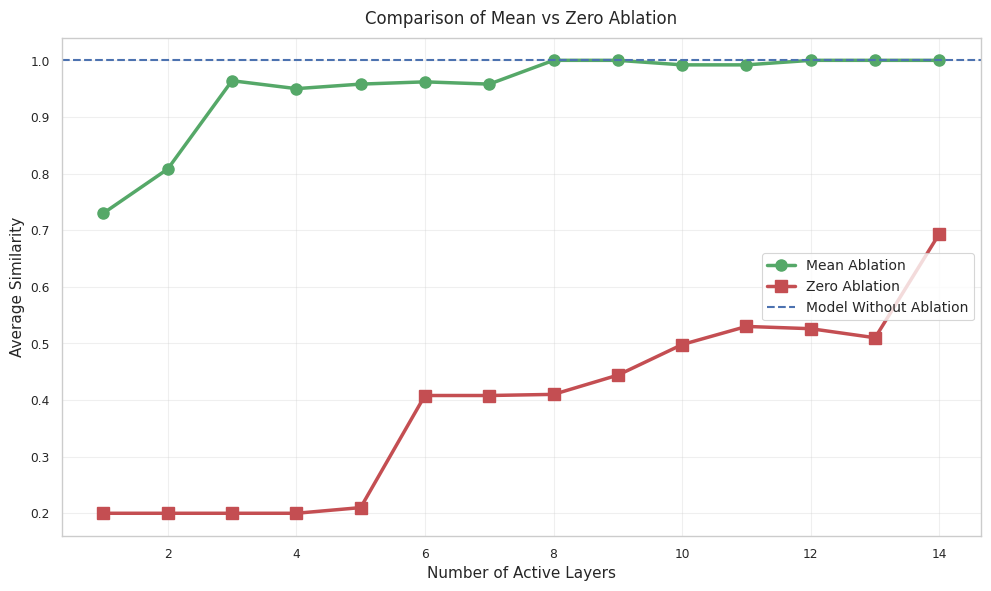

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

mean_x = [r['num_layers'] for r in mean_ablation_results]
mean_y = [r['avg_similarity'] for r in mean_ablation_results]
all_x = [r['num_layers'] for r in all_results]
all_y = [r['avg_similarity'] for r in all_results]

plot_ablation_comparison(
    mean_x=mean_x,
    mean_y=mean_y,
    zero_x=all_x,
    zero_y=all_y,
    baseline_value=1.0, 
    save_path_prefix='mean_ablation_vs_zero_nw_fixed') 

# ablating heads and MLPs

In [23]:
def compute_layer_means_all(model, prompt_texts):

    output_means = []
    mlp_means = []
    
    with model.generate(prompt_texts,max_new_tokens=7, pad_token_id=model.tokenizer.eos_token_id, temperature=0.5, 
                        top_p=0.9, eos_token_id=model.tokenizer.eos_token_id, do_sample=True, early_stopping=True) as tracer:
        
        for layer_idx in range(24):
            # Get attention output and compute mean
            output = model.model.layers[layer_idx].output[0]
            out_mean = output.mean(dim=0)  # Mean across batch dim
            output_means.append(out_mean.save())
            
            # Get MLP output and compute mean
            mlp_output = model.model.layers[layer_idx].mlp.output
            mlp_mean = mlp_output.mean(dim=0)  # Mean across batch dim
            mlp_means.append(mlp_mean.save())
            
    return output_means, mlp_means

def mean_ablation_all(model, prompt_text, target_layers, layer_means, all_output=False):

    output_means, mlp_means = layer_means
    
    with model.generate(prompt_text,max_new_tokens=7, pad_token_id=model.tokenizer.eos_token_id, temperature=0.5, 
                        top_p=0.9, eos_token_id=model.tokenizer.eos_token_id, do_sample=True, early_stopping=True) as tracer:
        
        hidden_states = []
        for layer_idx in range(24):
            # Get original outputs
            original_out = model.model.layers[layer_idx].output
            original_mlp = model.model.layers[layer_idx].mlp.output
            
            if layer_idx not in target_layers:
                # For non-target layers, replace with means
                out_mean = output_means[layer_idx]
                mlp_mean = mlp_means[layer_idx]
                
                modified_mlp = mlp_mean.unsqueeze(0).expand_as(original_mlp)
                model.model.layers[layer_idx].mlp.output = modified_mlp
                
                if all_output:
                    # Update outputs with means
                    modified_out = out_mean.unsqueeze(0).expand_as(original_out[0])
                    model.model.layers[layer_idx].output = (modified_out,) + original_out[1:]
                
            # Else: do nothing, keep original outputs for target layers
            
            # Store hidden states
            hidden_states.append(model.model.layers[layer_idx].output[0].save())
            
        out = model.generator.output.save()
        
    return hidden_states, out


layer_means = compute_layer_means_all(model, prompts_mean) 
target_layers = [0, 1, 7, 8, 9, 11, 13, 14, 15, 16, 18, 20, 21, 23]

results = []
for i, prompt in enumerate(prompts):
    hidden_states, tokens = mean_ablation_all(model, prompt, target_layers, layer_means, all_output=True)
    gen_text = model.tokenizer.decode(tokens[0].tolist()).split("Response: ")[1]
    gen_text = gen_text.replace("<|im_end|>", "").replace("<|im_sep|>", "").strip()

    similarity = calculate_similarity(gen_text, ref_answers[i])
    results.append({
        'output': gen_text,
        'similarity': similarity
    })

total_similarity = sum(r['similarity'] for r in results)
avg_similarity = total_similarity / len(results)
print(f"Average similarity: {avg_similarity}")

/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(


Average similarity: 0.23599999999999965


In [24]:
def zero_ablation_all(model, prompt_text, target_layers, all_output=False):

    with model.generate(prompt_text,max_new_tokens=7, pad_token_id=model.tokenizer.eos_token_id, temperature=0.5, 
                        top_p=0.9, eos_token_id=model.tokenizer.eos_token_id, do_sample=True, early_stopping=True) as tracer:
        
        hidden_states = []
        for layer_idx in range(24):
            # Get original outputs
            original_out = model.model.layers[layer_idx].output
            original_mlp = model.model.layers[layer_idx].mlp.output
            
            if layer_idx not in target_layers:
                # For non-target layers, replace with zeros
                # Create zeros with same shape as original outputs
                
                zero_mlp = torch.zeros_like(original_mlp)
                model.model.layers[layer_idx].mlp.output = zero_mlp
                
                # Update outputs with zeros
                if all_output:
                    zero_out = torch.zeros_like(original_out[0])
                    model.model.layers[layer_idx].output = (zero_out,) + original_out[1:]
                
            # Else: do nothing, keep original outputs for target layers
            
            # Store hidden states
            hidden_states.append(model.model.layers[layer_idx].output[0].save())
            
        out = model.generator.output.save()
        
    return hidden_states, out
    
target_layers = [0, 1, 7, 8, 9, 11, 13, 14, 15, 16, 18, 20, 21, 23]

results = []
for i, prompt in enumerate(prompts):
    hidden_states, tokens = zero_ablation_all(model, prompt, target_layers, all_output=True)
    gen_text = model.tokenizer.decode(tokens[0].tolist()).split("Response: ")[1]
    gen_text = gen_text.replace("<|im_end|>", "").replace("<|im_sep|>", "").strip()

    similarity = calculate_similarity(gen_text, ref_answers[i])
    results.append({
        'output': gen_text,
        'similarity': similarity
    })

total_similarity = sum(r['similarity'] for r in results)
avg_similarity = total_similarity / len(results)
print(f"Average similarity: {avg_similarity}")

Average similarity: 0.19999999999999962


In [25]:
# Original list of target layers
target_layers_full = [21, 8, 20, 9, 0, 1, 13, 16, 11, 14, 7, 18, 15, 23]

# Compute means once for all prompts
print("Computing layer means...")
layer_means = compute_layer_means_all(model, prompts_mean)

# Store results for each configuration
mean_ablation_all_results = []
zero_ablation_all_results = []

# Test mean ablation configuration
print("\nTesting Mean Ablation:")
for num_layers in range(1, len(target_layers_full) + 1):
    current_target_layers = target_layers_full[:num_layers]
    print(f"\nTesting with layers: {current_target_layers}")
    
    results = []
    for i, prompt in enumerate(prompts):
        hidden_states, tokens = mean_ablation_all(model, prompt, target_layers_full, layer_means, all_output=True)
        gen_text = model.tokenizer.decode(tokens[0].tolist()).split("Response: ")[1]
        gen_text = gen_text.replace("<|im_end|>", "").replace("<|im_sep|>", "").strip()

        similarity = calculate_similarity(gen_text, ref_answers[i])
        results.append({
            'output': gen_text,
            'similarity': similarity
        })
    
    avg_similarity = sum(r['similarity'] for r in results) / len(results)
    mean_ablation_all_results.append({
        'target_layers': current_target_layers,
        'num_layers': num_layers,
        'avg_similarity': avg_similarity,
        'detailed_results': results
    })
    print(f"Number of layers: {num_layers}")
    print(f"Average similarity: {avg_similarity}")

# Test zero ablation configuration
print("\nTesting Zero Ablation:")
for num_layers in range(1, len(target_layers_full) + 1):
    current_target_layers = target_layers_full[:num_layers]
    print(f"\nTesting with layers: {current_target_layers}")
    
    results = []
    for i, prompt in enumerate(prompts):
        hidden_states, tokens = zero_ablation_all(model, prompt, target_layers_full, all_output=True)
        gen_text = model.tokenizer.decode(tokens[0].tolist()).split("Response: ")[1]
        gen_text = gen_text.replace("<|im_end|>", "").replace("<|im_sep|>", "").strip()

        similarity = calculate_similarity(gen_text, ref_answers[i])
        results.append({
            'output': gen_text,
            'similarity': similarity
        })
    
    avg_similarity = sum(r['similarity'] for r in results) / len(results)
    zero_ablation_all_results.append({
        'target_layers': current_target_layers,
        'num_layers': num_layers,
        'avg_similarity': avg_similarity,
        'detailed_results': results
    })
    print(f"Number of layers: {num_layers}")
    print(f"Average similarity: {avg_similarity}")


Computing layer means...

Testing Mean Ablation:

Testing with layers: [21]
Number of layers: 1
Average similarity: 0.2319999999999996

Testing with layers: [21, 8]
Number of layers: 2
Average similarity: 0.22999999999999965

Testing with layers: [21, 8, 20]
Number of layers: 3
Average similarity: 0.24399999999999955

Testing with layers: [21, 8, 20, 9]
Number of layers: 4
Average similarity: 0.23199999999999965

Testing with layers: [21, 8, 20, 9, 0]
Number of layers: 5
Average similarity: 0.22399999999999964

Testing with layers: [21, 8, 20, 9, 0, 1]
Number of layers: 6
Average similarity: 0.2339999999999996

Testing with layers: [21, 8, 20, 9, 0, 1, 13]
Number of layers: 7
Average similarity: 0.23399999999999962

Testing with layers: [21, 8, 20, 9, 0, 1, 13, 16]
Number of layers: 8
Average similarity: 0.24199999999999963

Testing with layers: [21, 8, 20, 9, 0, 1, 13, 16, 11]
Number of layers: 9
Average similarity: 0.2259999999999996

Testing with layers: [21, 8, 20, 9, 0, 1, 13, 16,

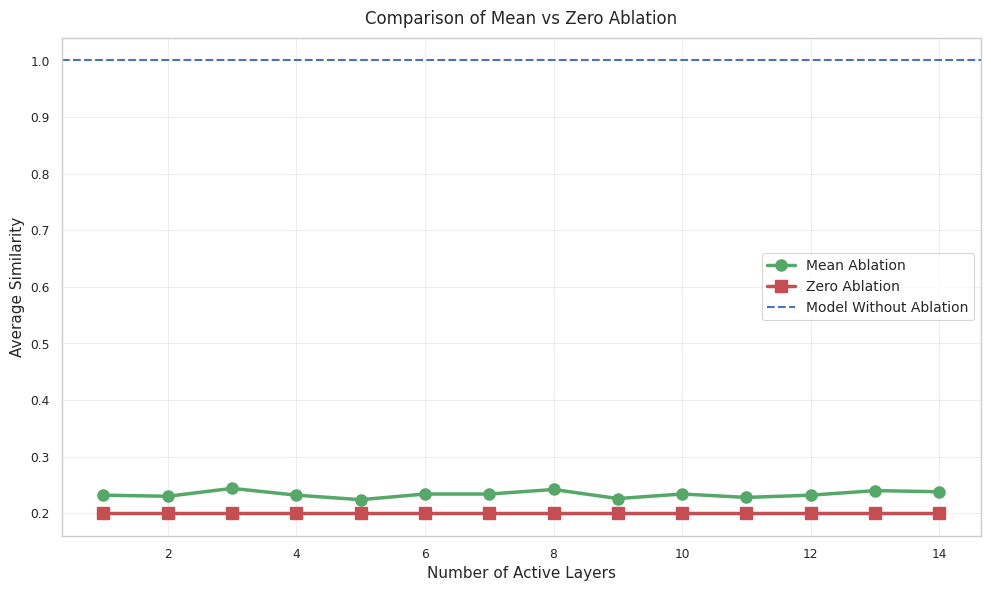

In [27]:
mean_x_all = [r['num_layers'] for r in mean_ablation_all_results]
mean_y_all = [r['avg_similarity'] for r in mean_ablation_all_results]
zero_x_all = [r['num_layers'] for r in zero_ablation_all_results]
zero_y_all = [r['avg_similarity'] for r in zero_ablation_all_results]

plot_ablation_comparison(
    mean_x=mean_x_all,
    mean_y=mean_y_all,
    zero_x=zero_x_all,
    zero_y=zero_y_all,
    baseline_value=1.0, 
    save_path_prefix='mean_ablation_vs_zero_all_fixed')

# Only MLPs

In [28]:
# Original list of target layers
target_layers_full = [21, 8, 20, 9, 0, 1, 13, 16, 11, 14, 7, 18, 15, 23]

# Compute means once for all prompts
print("Computing layer means...")
layer_means = compute_layer_means_all(model, prompts_mean)

# Store results for each configuration
mean_ablation_mlp_results = []
zero_ablation_mlp_results = []

# Test mean ablation configuration
print("\nTesting Mean Ablation:")
for num_layers in range(1, len(target_layers_full) + 1):
    current_target_layers = target_layers_full[:num_layers]
    print(f"\nTesting with layers: {current_target_layers}")
    
    results = []
    for i, prompt in enumerate(prompts):
        hidden_states, tokens = mean_ablation_all(model, prompt, target_layers_full, layer_means, all_output=False)
        gen_text = model.tokenizer.decode(tokens[0].tolist()).split("Response: ")[1]
        gen_text = gen_text.replace("<|im_end|>", "").replace("<|im_sep|>", "").strip()

        similarity = calculate_similarity(gen_text, ref_answers[i])
        results.append({
            'output': gen_text,
            'similarity': similarity
        })
    
    avg_similarity = sum(r['similarity'] for r in results) / len(results)
    mean_ablation_mlp_results.append({
        'target_layers': current_target_layers,
        'num_layers': num_layers,
        'avg_similarity': avg_similarity,
        'detailed_results': results
    })
    print(f"Number of layers: {num_layers}")
    print(f"Average similarity: {avg_similarity}")

# Test zero ablation configuration
print("\nTesting Zero Ablation:")
for num_layers in range(1, len(target_layers_full) + 1):
    current_target_layers = target_layers_full[:num_layers]
    print(f"\nTesting with layers: {current_target_layers}")
    
    results = []
    for i, prompt in enumerate(prompts):
        hidden_states, tokens = zero_ablation_all(model, prompt, target_layers_full, all_output=False)
        gen_text = model.tokenizer.decode(tokens[0].tolist()).split("Response: ")[1]
        gen_text = gen_text.replace("<|im_end|>", "").replace("<|im_sep|>", "").strip()

        similarity = calculate_similarity(gen_text, ref_answers[i])
        results.append({
            'output': gen_text,
            'similarity': similarity
        })
    
    avg_similarity = sum(r['similarity'] for r in results) / len(results)
    zero_ablation_mlp_results.append({
        'target_layers': current_target_layers,
        'num_layers': num_layers,
        'avg_similarity': avg_similarity,
        'detailed_results': results
    })
    print(f"Number of layers: {num_layers}")
    print(f"Average similarity: {avg_similarity}")


Computing layer means...


/opt/conda/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:676: UserWarning: `num_beams` is set to 1. However, `early_stopping` is set to `True` -- this flag is only used in beam-based generation modes. You should set `num_beams>1` or unset `early_stopping`.
  warnings.warn(



Testing Mean Ablation:

Testing with layers: [21]
Number of layers: 1
Average similarity: 1.0

Testing with layers: [21, 8]
Number of layers: 2
Average similarity: 1.0

Testing with layers: [21, 8, 20]
Number of layers: 3
Average similarity: 1.0

Testing with layers: [21, 8, 20, 9]
Number of layers: 4
Average similarity: 1.0

Testing with layers: [21, 8, 20, 9, 0]
Number of layers: 5
Average similarity: 1.0

Testing with layers: [21, 8, 20, 9, 0, 1]
Number of layers: 6
Average similarity: 1.0

Testing with layers: [21, 8, 20, 9, 0, 1, 13]
Number of layers: 7
Average similarity: 1.0

Testing with layers: [21, 8, 20, 9, 0, 1, 13, 16]
Number of layers: 8
Average similarity: 1.0

Testing with layers: [21, 8, 20, 9, 0, 1, 13, 16, 11]
Number of layers: 9
Average similarity: 1.0

Testing with layers: [21, 8, 20, 9, 0, 1, 13, 16, 11, 14]
Number of layers: 10
Average similarity: 1.0

Testing with layers: [21, 8, 20, 9, 0, 1, 13, 16, 11, 14, 7]
Number of layers: 11
Average similarity: 1.0

Test

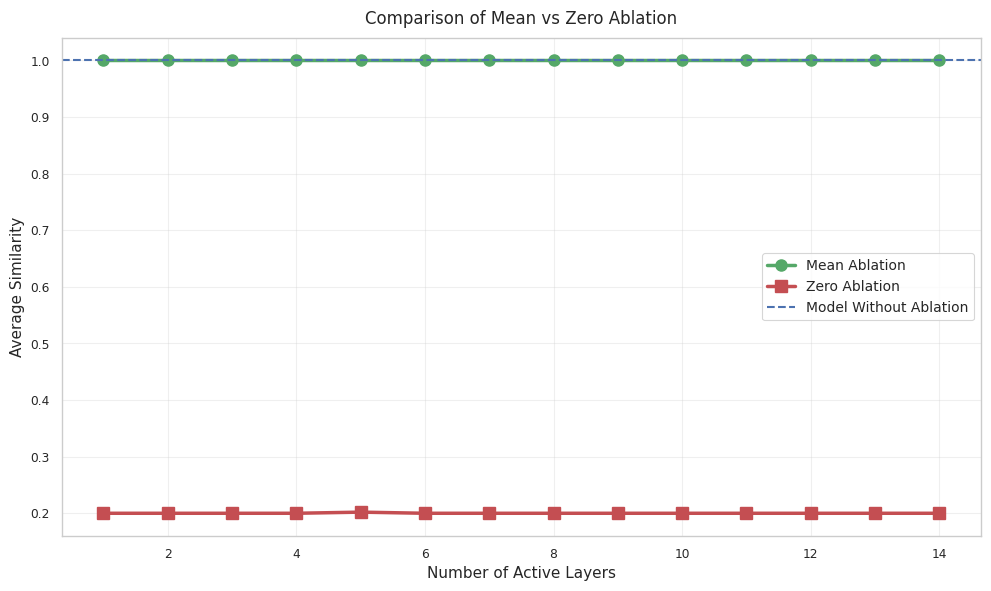

In [30]:
mean_x_mlp = [r['num_layers'] for r in mean_ablation_mlp_results]
mean_y_mlp = [r['avg_similarity'] for r in mean_ablation_mlp_results]
zero_x_mlp = [r['num_layers'] for r in zero_ablation_mlp_results]
zero_y_mlp = [r['avg_similarity'] for r in zero_ablation_mlp_results]

plot_ablation_comparison(
    mean_x=mean_x_mlp,
    mean_y=mean_y_mlp,
    zero_x=zero_x_mlp,
    zero_y=zero_y_mlp,
    baseline_value=1.0, 
    save_path_prefix='mean_ablation_vs_zero_mlp_fixed') 
